# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 16      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 128
  d_ff                      : 64
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 2
  num_heads                 : 12
  dropout                   : 0.2

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [5]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.025063  0.022758  0.020406  0.289462
2015-01-05  0.020931  0.019052  0.017820  0.361694
2015-01-06  0.018597  0.017431  0.016780  0.371548
2015-01-07  0.019477  0.018454  0.019540  0.204077
2015-01-08  0.022184  0.023701  0.022206  0.329616
after normalization dataset is Date
2015-01-02    0.021795
2015-01-05    0.017699
2015-01-06    0.017712
2015-01-07    0.019694
2015-01-08    0.025199
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')


Processing AAPL (train): 100%|███████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 15690.10it/s]
[*********************100%***********************]  1 of 1 completed


x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shift

Processing AAPL (val): 100%|███████████████████████████████████████████████████████| 187/187 [00:00<00:00, 18695.11it/s]

x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shift

In [6]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [7]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config).to(device)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets_shifted, targets_shifted_targfeat, targets_golden = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets_shifted[0].shape))
    print(targets_shifted[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets_shifted.shape)
    break

summary(model, input_data=(targets_shifted.to(device), targets_shifted_targfeat.to(device)))


6 1
First input sample (shape: torch.Size([5, 6])):
tensor([[0.0251, 0.0228, 0.0204, 0.0218, 0.2895, 0.0000],
        [0.0209, 0.0191, 0.0178, 0.0177, 0.3617, 1.0000],
        [0.0186, 0.0174, 0.0168, 0.0177, 0.3715, 2.0000],
        [0.0195, 0.0185, 0.0195, 0.0197, 0.2041, 3.0000],
        [0.0222, 0.0237, 0.0222, 0.0252, 0.3296, 4.0000]])
Corresponding target (shape: torch.Size([5, 6])):
tensor([[0.0251, 0.0228, 0.0204, 0.0218, 0.2895, 0.0000],
        [0.0251, 0.0228, 0.0204, 0.0218, 0.2895, 0.0000],
        [0.0209, 0.0191, 0.0178, 0.0177, 0.3617, 1.0000],
        [0.0186, 0.0174, 0.0168, 0.0177, 0.3715, 2.0000],
        [0.0195, 0.0185, 0.0195, 0.0197, 0.2041, 3.0000]])
Inputs: torch.Size([16, 5, 6])
Targets: torch.Size([16, 5, 6])


Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [16, 5, 1]                1
├─Sequential: 1-1                             [16, 5, 128]              --
│    └─Linear: 2-1                            [16, 5, 128]              768
│    └─GELU: 2-2                              [16, 5, 128]              --
│    └─Dropout: 2-3                           [16, 5, 128]              --
│    └─Linear: 2-4                            [16, 5, 128]              16,512
│    └─GELU: 2-5                              [16, 5, 128]              --
│    └─Dropout: 2-6                           [16, 5, 128]              --
├─Time2VecTorch: 1-2                          [16, 5, 4]                8
├─TimeSeriesPositionalEncoding: 1-3           [16, 5, 132]              --
├─Dropout: 1-4                                [16, 5, 132]              --
├─Linear: 1-5                                 [16, 5, 128]              256
├─Time2VecTorch:

# STEP 3: Setup WandB and Trainer

In [8]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc
wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
# wandb.finish()

In [10]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (1005 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (335 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


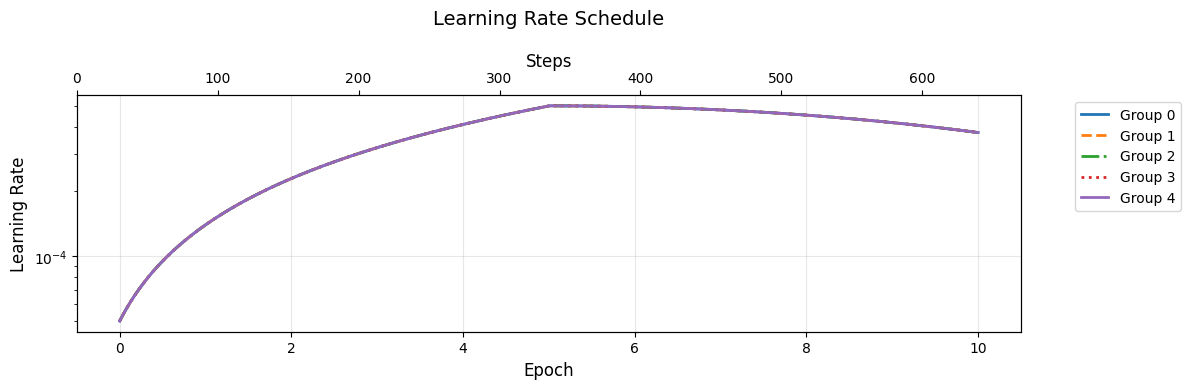

In [11]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
# if trainer.use_wandb:
#     wandb.init(
#         project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
#         config=trainer.config,
#         name=trainer.run_name,
#         settings=wandb.Settings(
#         start_method="thread",             # don't spawn multiprocessing process
#         )
#     )


# Step 4: TRAIN!!   

In [12]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                                                  | 0/67 [00:00<?, ?it/s]

/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training:   3%|▉                             | 2/67 [00:00<00:23,  2.72it/s, batch_accuracy=1.25%, loss=0.0050, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007593106012791395
abm_loss is 0.007303355727344751
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005658478010445833
abm_loss is 0.0056364755146205425
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  19%|█████▋                       | 13/67 [00:00<00:02, 26.80it/s, batch_accuracy=7.50%, loss=0.0049, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005160217639058828
abm_loss is 0.005224817898124456
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005089700222015381
abm_loss is 0.005336344707757235
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  36%|██████████                  | 24/67 [00:00<00:01, 37.35it/s, batch_accuracy=13.75%, loss=0.0033, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004839298781007528
abm_loss is 0.0048812078312039375
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0054254005663096905
abm_loss is 0.005380346905440092
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  51%|██████████████▏             | 34/67 [00:01<00:00, 44.12it/s, batch_accuracy=16.25%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035602159332484007
abm_loss is 0.0034404166508466005
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003504733322188258
abm_loss is 0.003360901726409793
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  66%|███████████████████          | 44/67 [00:01<00:00, 46.70it/s, batch_accuracy=0.00%, loss=0.0833, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003383835544809699
abm_loss is 0.0034027346409857273
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003721771528944373
abm_loss is 0.003981546964496374
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  82%|██████████████████████▉     | 55/67 [00:01<00:00, 48.47it/s, batch_accuracy=12.50%, loss=0.0561, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.05004017427563667
abm_loss is 0.046004582196474075
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0555998794734478
abm_loss is 0.05504349619150162
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  97%|███████████████████████████▏| 65/67 [00:01<00:00, 48.63it/s, batch_accuracy=65.00%, loss=0.0092, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.020660733804106712
abm_loss is 0.020520158112049103
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011762226931750774
abm_loss is 0.01630420796573162
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 38.72it/s, batch_accuracy=56.00%, loss=0.0119, mae=nan]


resturns shape is torch.Size([10, 5, 1])
mu shape is torch.Size([10, 1, 1])
sigma shape is torch.Size([10, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([10, 5, 1])
W_t shape is torch.Size([10, 5, 1])
X_0 shape is torch.Size([10, 5, 1])
mu_term shape is torch.Size([10, 5, 1])
sigma_term shape is torch.Size([10, 5, 1])
abm_path shape is torch.Size([10, 5, 1])
mse_loss is 0.0119178993627429
abm_loss is 0.01394803635776043

📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 0.0172 | train_mae: nan | train_accuracy: 13.3021


Training:   0%|                                      | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.1866, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.18657130002975464
abm_loss is 0.18454623222351074


Training:  13%|████                          | 9/67 [00:00<00:01, 37.29it/s, batch_accuracy=0.00%, loss=0.3378, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.3598949909210205
abm_loss is 0.35983189940452576
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.4320422112941742
abm_loss is 0.43100863695144653
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training:  15%|████▎                        | 10/67 [00:00<00:01, 37.29it/s, batch_accuracy=0.00%, loss=0.3102, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.3102153241634369
abm_loss is 0.3115822672843933


Training:  28%|████████▏                    | 19/67 [00:00<00:01, 44.83it/s, batch_accuracy=5.00%, loss=0.0150, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.23534558713436127
abm_loss is 0.23584997653961182
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.20408105850219727
abm_loss is 0.20184147357940674
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  30%|████████▋                    | 20/67 [00:00<00:01, 44.83it/s, batch_accuracy=7.50%, loss=0.0056, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005632204469293356
abm_loss is 0.005930106621235609


Training:  43%|████████████▌                | 29/67 [00:00<00:00, 48.07it/s, batch_accuracy=0.00%, loss=0.0417, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004554645158350468
abm_loss is 0.004579829517751932
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003693211590871215
abm_loss is 0.003800332546234131
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  60%|█████████████████▎           | 40/67 [00:00<00:00, 48.43it/s, batch_accuracy=1.25%, loss=0.0428, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013915312476456165
abm_loss is 0.014586158096790314
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01522733923047781
abm_loss is 0.015473944135010242
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  75%|█████████████████████▋       | 50/67 [00:01<00:00, 49.02it/s, batch_accuracy=0.00%, loss=0.1373, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.034400444477796555
abm_loss is 0.03640132024884224
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.05884672328829765
abm_loss is 0.057248856872320175
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  90%|█████████████████████████▉   | 60/67 [00:01<00:00, 48.91it/s, batch_accuracy=5.00%, loss=0.0806, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.19418922066688538
abm_loss is 0.20127499103546143
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.1728915423154831
abm_loss is 0.17919977009296417
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training: 100%|█████████████████████████████| 67/67 [00:01<00:00, 46.23it/s, batch_accuracy=4.00%, loss=0.0695, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.030889853835105896
abm_loss is 0.029971778392791748
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.025572990998625755
abm_loss is 0.03212737664580345
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 38.70it/s, batch_accuracy=0.00%, loss=0.3496, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005523666739463806
abm_loss is 0.005631342064589262
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.032700251787900925
abm_loss is 0.032355815172195435
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  27%|███████▊                     | 18/67 [00:00<00:01, 44.89it/s, batch_accuracy=0.00%, loss=0.0837, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.38121309876441956
abm_loss is 0.3823133111000061
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.3505885899066925
abm_loss is 0.34931811690330505
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.57it/s, batch_accuracy=15.00%, loss=0.0060, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.044951826333999634
abm_loss is 0.0454799085855484
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03363349661231041
abm_loss is 0.03367538005113602
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  58%|████████████████▉            | 39/67 [00:00<00:00, 47.59it/s, batch_accuracy=0.00%, loss=0.0452, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0029647252522408962
abm_loss is 0.0028028790839016438
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013402491807937622
abm_loss is 0.013645604252815247
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  75%|█████████████████████▋       | 50/67 [00:01<00:00, 48.68it/s, batch_accuracy=0.00%, loss=0.1509, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.025610143318772316
abm_loss is 0.02841724269092083
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.05827672407031059
abm_loss is 0.05909324809908867
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  90%|█████████████████████████▉   | 60/67 [00:01<00:00, 49.15it/s, batch_accuracy=0.00%, loss=0.1133, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.2237558364868164
abm_loss is 0.2303456813097
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.2303345501422882
abm_loss is 0.22278347611427307
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1

Training: 100%|█████████████████████████████| 67/67 [00:01<00:00, 46.23it/s, batch_accuracy=0.00%, loss=0.1221, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06947576999664307
abm_loss is 0.06746251881122589
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04232993349432945
abm_loss is 0.044666167348623276
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  12%|███▌                          | 8/67 [00:00<00:01, 37.64it/s, batch_accuracy=0.00%, loss=0.2839, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.038581784814596176
abm_loss is 0.03928474709391594
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012292840518057346
abm_loss is 0.012040960602462292
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.48it/s, batch_accuracy=0.00%, loss=0.1212, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.3011493384838104
abm_loss is 0.3011702001094818
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.2991173267364502
abm_loss is 0.29840418696403503
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16

Training:  43%|████████████▌                | 29/67 [00:00<00:00, 47.07it/s, batch_accuracy=7.50%, loss=0.0082, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.10828649252653122
abm_loss is 0.11010482162237167
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.08303146809339523
abm_loss is 0.08291658014059067
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  60%|█████████████████▎           | 40/67 [00:00<00:00, 48.72it/s, batch_accuracy=0.00%, loss=0.0335, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007356517948210239
abm_loss is 0.007628695107996464
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01214359886944294
abm_loss is 0.011436444707214832
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  75%|█████████████████████▋       | 50/67 [00:01<00:00, 48.44it/s, batch_accuracy=0.00%, loss=0.1851, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0183416698127985
abm_loss is 0.017282573506236076
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04773205146193504
abm_loss is 0.045429836958646774
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  91%|██████████████████████████▍  | 61/67 [00:01<00:00, 49.21it/s, batch_accuracy=0.00%, loss=0.1457, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.23951683938503265
abm_loss is 0.24425938725471497
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.2543085515499115
abm_loss is 0.2652786374092102
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training: 100%|█████████████████████████████| 67/67 [00:01<00:00, 46.40it/s, batch_accuracy=0.00%, loss=0.1644, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06398963183164597
abm_loss is 0.06664042919874191
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07388994097709656
abm_loss is 0.07535164058208466
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  13%|████                          | 9/67 [00:00<00:01, 36.00it/s, batch_accuracy=0.00%, loss=0.1886, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06168464571237564
abm_loss is 0.06129724904894829
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.019743772223591805
abm_loss is 0.019857535138726234
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.57it/s, batch_accuracy=0.00%, loss=0.1261, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.20765237510204315
abm_loss is 0.20827901363372803
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.2192855328321457
abm_loss is 0.22052498161792755
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 47.16it/s, batch_accuracy=10.00%, loss=0.0132, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.09522794932126999
abm_loss is 0.0948471948504448
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.08166152983903885
abm_loss is 0.08048836886882782
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training:  60%|█████████████████▎           | 40/67 [00:00<00:00, 48.56it/s, batch_accuracy=8.75%, loss=0.0245, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02365667186677456
abm_loss is 0.023726610466837883
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012555146589875221
abm_loss is 0.012634092941880226
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  75%|█████████████████████▋       | 50/67 [00:01<00:00, 48.50it/s, batch_accuracy=0.00%, loss=0.1466, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01870122365653515
abm_loss is 0.02099807932972908
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03714841976761818
abm_loss is 0.038972269743680954
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  90%|█████████████████████████▉   | 60/67 [00:01<00:00, 48.95it/s, batch_accuracy=0.00%, loss=0.1127, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.2188209742307663
abm_loss is 0.21833865344524384
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.22777195274829865
abm_loss is 0.23243360221385956
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training: 100%|█████████████████████████████| 67/67 [00:01<00:00, 45.99it/s, batch_accuracy=0.00%, loss=0.0935, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06550057977437973
abm_loss is 0.07799910753965378
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03601967170834541
abm_loss is 0.03559054434299469
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  12%|███▌                          | 8/67 [00:00<00:01, 37.71it/s, batch_accuracy=0.00%, loss=0.1643, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.029655206948518753
abm_loss is 0.029889468103647232
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.016210809350013733
abm_loss is 0.0160038024187088
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 44.67it/s, batch_accuracy=0.00%, loss=0.1232, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.22949469089508057
abm_loss is 0.2316122055053711
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.24664989113807678
abm_loss is 0.2459099292755127
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training:  42%|████████████                 | 28/67 [00:00<00:00, 46.56it/s, batch_accuracy=6.25%, loss=0.0111, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.10241925716400146
abm_loss is 0.10040584951639175
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.08940689265727997
abm_loss is 0.08980293571949005
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  57%|███████████████▉            | 38/67 [00:00<00:00, 47.27it/s, batch_accuracy=13.75%, loss=0.0066, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.014211880974471569
abm_loss is 0.013249424286186695
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.022174278274178505
abm_loss is 0.021147407591342926
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  72%|████████████████████▊        | 48/67 [00:01<00:00, 47.93it/s, batch_accuracy=0.00%, loss=0.1574, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.017287779599428177
abm_loss is 0.018783729523420334
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.009878219105303288
abm_loss is 0.011938082985579967
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  88%|█████████████████████████▌   | 59/67 [00:01<00:00, 48.42it/s, batch_accuracy=0.00%, loss=0.1582, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.15258140861988068
abm_loss is 0.15140405297279358
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.21734009683132172
abm_loss is 0.22242441773414612
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training: 100%|█████████████████████████████| 67/67 [00:01<00:00, 45.69it/s, batch_accuracy=0.00%, loss=0.1384, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.12289614975452423
abm_loss is 0.11193197220563889
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07405629754066467
abm_loss is 0.0721561536192894
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training:  13%|████                          | 9/67 [00:00<00:03, 15.93it/s, batch_accuracy=0.00%, loss=0.1306, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02577219344675541
abm_loss is 0.025371646508574486
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0186659786850214
abm_loss is 0.019095219671726227
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 32.90it/s, batch_accuracy=0.00%, loss=0.1280, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.15347516536712646
abm_loss is 0.15433132648468018
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.17187082767486572
abm_loss is 0.17237217724323273
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  43%|████████████▌                | 29/67 [00:00<00:00, 41.71it/s, batch_accuracy=1.25%, loss=0.0161, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.11120717972517014
abm_loss is 0.1125420331954956
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.09881167858839035
abm_loss is 0.09991343319416046
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training:  60%|████████████████▋           | 40/67 [00:01<00:00, 45.30it/s, batch_accuracy=11.25%, loss=0.0178, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.031154543161392212
abm_loss is 0.032108526676893234
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.024343034252524376
abm_loss is 0.023943394422531128
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  75%|█████████████████████▋       | 50/67 [00:01<00:00, 47.68it/s, batch_accuracy=0.00%, loss=0.1360, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008776485919952393
abm_loss is 0.010398841463029385
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.030989838764071465
abm_loss is 0.02811416983604431
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  91%|██████████████████████████▍  | 61/67 [00:01<00:00, 48.36it/s, batch_accuracy=0.00%, loss=0.1047, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.19730804860591888
abm_loss is 0.19353033602237701
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.20767433941364288
abm_loss is 0.20484529435634613
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training: 100%|█████████████████████████████| 67/67 [00:01<00:00, 38.79it/s, batch_accuracy=0.00%, loss=0.1370, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.05064674839377403
abm_loss is 0.04969380050897598
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.039811789989471436
abm_loss is 0.04677414149045944
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  13%|████                          | 9/67 [00:00<00:01, 36.33it/s, batch_accuracy=0.00%, loss=0.0773, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0280271228402853
abm_loss is 0.02825680375099182
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.027087166905403137
abm_loss is 0.02695140242576599
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.60it/s, batch_accuracy=0.00%, loss=0.1385, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.10623190551996231
abm_loss is 0.10621519386768341
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.13623051345348358
abm_loss is 0.13614769279956818
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  43%|████████████▌                | 29/67 [00:00<00:00, 47.33it/s, batch_accuracy=5.00%, loss=0.0177, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.116152323782444
abm_loss is 0.11527558416128159
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.10009117424488068
abm_loss is 0.09900062531232834
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training:  58%|████████████████▉            | 39/67 [00:00<00:00, 48.53it/s, batch_accuracy=2.50%, loss=0.0261, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.024528732523322105
abm_loss is 0.025569437071681023
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0360557995736599
abm_loss is 0.036392297595739365
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  75%|█████████████████████▋       | 50/67 [00:01<00:00, 48.77it/s, batch_accuracy=0.00%, loss=0.1404, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.024189433082938194
abm_loss is 0.02409552037715912
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012781328521668911
abm_loss is 0.01147378794848919
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  87%|█████████████████████████    | 58/67 [00:01<00:00, 48.99it/s, batch_accuracy=2.50%, loss=0.0587, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.1244950070977211
abm_loss is 0.1282029002904892
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.20462723076343536
abm_loss is 0.20119719207286835
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 45.99it/s, batch_accuracy=12.00%, loss=0.0599, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06617634743452072
abm_loss is 0.06852211058139801
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02965606562793255
abm_loss is 0.035675473511219025
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  12%|███▌                          | 8/67 [00:00<00:01, 39.40it/s, batch_accuracy=0.00%, loss=0.0373, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01942835934460163
abm_loss is 0.019422298297286034
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02155490219593048
abm_loss is 0.02166799083352089
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 46.03it/s, batch_accuracy=0.00%, loss=0.1405, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06305130571126938
abm_loss is 0.06431083381175995
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.1041860356926918
abm_loss is 0.10461419075727463
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training:  43%|████████████▌                | 29/67 [00:00<00:00, 47.38it/s, batch_accuracy=6.25%, loss=0.0249, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.11979620903730392
abm_loss is 0.11965233087539673
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.11512430012226105
abm_loss is 0.1143689975142479
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.74it/s, batch_accuracy=21.25%, loss=0.0111, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03593854606151581
abm_loss is 0.03631623089313507
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04763571172952652
abm_loss is 0.04842991381883621
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  76%|██████████████████████       | 51/67 [00:01<00:00, 48.65it/s, batch_accuracy=0.00%, loss=0.1250, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006312721408903599
abm_loss is 0.008019231259822845
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.018969569355249405
abm_loss is 0.019818158820271492
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  90%|█████████████████████████▉   | 60/67 [00:01<00:00, 49.00it/s, batch_accuracy=6.25%, loss=0.0780, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.18190538883209229
abm_loss is 0.18968303501605988
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.1716192215681076
abm_loss is 0.17045354843139648
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training: 100%|█████████████████████████████| 67/67 [00:01<00:00, 46.58it/s, batch_accuracy=4.00%, loss=0.0625, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.016349613666534424
abm_loss is 0.017107291147112846
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01956452988088131
abm_loss is 0.024264467880129814
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 40.10it/s, batch_accuracy=2.50%, loss=0.0124, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011983527801930904
abm_loss is 0.012171946465969086
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.014858001843094826
abm_loss is 0.014904618263244629
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.19it/s, batch_accuracy=0.00%, loss=0.0909, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.029963452368974686
abm_loss is 0.029790574684739113
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04128267988562584
abm_loss is 0.04125411435961723
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  45%|████████████▉                | 30/67 [00:00<00:00, 48.07it/s, batch_accuracy=1.25%, loss=0.0505, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.10972850769758224
abm_loss is 0.11018524318933487
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.09888286888599396
abm_loss is 0.09936172515153885
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.63it/s, batch_accuracy=31.25%, loss=0.0069, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07266444712877274
abm_loss is 0.07066967338323593
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.05394602566957474
abm_loss is 0.05429423600435257
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  76%|██████████████████████       | 51/67 [00:01<00:00, 48.81it/s, batch_accuracy=0.00%, loss=0.1005, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005973182152956724
abm_loss is 0.005762767046689987
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.016932999715209007
abm_loss is 0.019003409892320633
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.30it/s, batch_accuracy=22.50%, loss=0.0442, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.1645364910364151
abm_loss is 0.1636541783809662
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.15027467906475067
abm_loss is 0.1489604264497757
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.26it/s, batch_accuracy=32.00%, loss=0.0382, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01805543713271618
abm_loss is 0.01861346699297428
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.017335308715701103
abm_loss is 0.018160229548811913
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:   0%|                                                                                  | 0/67 [00:00<?, ?it/s]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006321643479168415
abm_loss is 0.0063727558590471745


Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.71it/s, batch_accuracy=0.00%, loss=0.0023, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010267443023622036
abm_loss is 0.010180552490055561
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.009518766775727272
abm_loss is 0.009475084021687508
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  15%|████▎                        | 10/67 [00:00<00:01, 38.71it/s, batch_accuracy=0.00%, loss=0.0059, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005880901589989662
abm_loss is 0.005782592575997114


Training:  28%|████████▏                    | 19/67 [00:00<00:01, 46.41it/s, batch_accuracy=0.00%, loss=0.0730, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.020288942381739616
abm_loss is 0.020398087799549103
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02253611385822296
abm_loss is 0.022516265511512756
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  30%|████████▋                    | 20/67 [00:00<00:01, 46.41it/s, batch_accuracy=1.25%, loss=0.0512, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])


Training:  43%|████████████▌                | 29/67 [00:00<00:00, 47.19it/s, batch_accuracy=1.25%, loss=0.0466, mae=nan]

sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.098915234208107
abm_loss is 0.0992283821105957
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06968419253826141
abm_loss is 0.06870730966329575
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16,

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.78it/s, batch_accuracy=28.75%, loss=0.0086, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.08585473895072937
abm_loss is 0.08308666199445724
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07009553909301758
abm_loss is 0.070264533162117
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training:  75%|█████████████████████▋       | 50/67 [00:01<00:00, 48.63it/s, batch_accuracy=1.25%, loss=0.0802, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01416280772536993
abm_loss is 0.014412610791623592
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.031478941440582275
abm_loss is 0.026702433824539185
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.40it/s, batch_accuracy=28.75%, loss=0.0229, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.13244448602199554
abm_loss is 0.13592420518398285
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.10750336945056915
abm_loss is 0.10883920639753342
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.43it/s, batch_accuracy=44.00%, loss=0.0295, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.030617956072092056
abm_loss is 0.032084256410598755
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02670539729297161
abm_loss is 0.028300095349550247
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 39.90it/s, batch_accuracy=6.25%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001305261394008994
abm_loss is 0.001380309695377946
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002007639268413186
abm_loss is 0.002090156776830554
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.74it/s, batch_accuracy=2.50%, loss=0.0242, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0042741186916828156
abm_loss is 0.004229644779115915
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004031747579574585
abm_loss is 0.003964078612625599
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  43%|████████████▌                | 29/67 [00:00<00:00, 47.64it/s, batch_accuracy=3.75%, loss=0.0512, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04031207412481308
abm_loss is 0.04025169834494591
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.052271392196416855
abm_loss is 0.05254961922764778
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.25it/s, batch_accuracy=26.25%, loss=0.0094, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.058792125433683395
abm_loss is 0.05762289837002754
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07545315474271774
abm_loss is 0.07299406826496124
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  73%|█████████████████████▏       | 49/67 [00:01<00:00, 48.70it/s, batch_accuracy=2.50%, loss=0.0795, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008340432308614254
abm_loss is 0.011165671981871128
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007611491717398167
abm_loss is 0.009313371963799
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  88%|████████████████████████▋   | 59/67 [00:01<00:00, 49.19it/s, batch_accuracy=33.75%, loss=0.0352, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.08326585590839386
abm_loss is 0.08417128026485443
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07543458044528961
abm_loss is 0.07179688662290573
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.25it/s, batch_accuracy=32.00%, loss=0.0369, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.030570844188332558
abm_loss is 0.03260187432169914
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03225768730044365
abm_loss is 0.02882484905421734
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  12%|███▌                          | 8/67 [00:00<00:01, 36.58it/s, batch_accuracy=0.00%, loss=0.0010, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004481151700019836
abm_loss is 0.00446377694606781
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004599886015057564
abm_loss is 0.004898204002529383
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.42it/s, batch_accuracy=11.25%, loss=0.0136, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016976807964965701
abm_loss is 0.0017401138320565224
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0028635181952267885
abm_loss is 0.002808418357744813
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  43%|████████████▌                | 29/67 [00:00<00:00, 47.17it/s, batch_accuracy=8.75%, loss=0.0338, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01000531017780304
abm_loss is 0.009783494286239147
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02505641058087349
abm_loss is 0.025279680266976357
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.65it/s, batch_accuracy=25.00%, loss=0.0116, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.052604448050260544
abm_loss is 0.056739844381809235
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06849217414855957
abm_loss is 0.06752563267946243
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  73%|█████████████████████▏       | 49/67 [00:01<00:00, 48.72it/s, batch_accuracy=5.00%, loss=0.0706, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00950381625443697
abm_loss is 0.008827419951558113
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008693183772265911
abm_loss is 0.010555259883403778
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  88%|████████████████████████▋   | 59/67 [00:01<00:00, 48.44it/s, batch_accuracy=25.00%, loss=0.0325, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07771908491849899
abm_loss is 0.08284639567136765
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0773366317152977
abm_loss is 0.08160191029310226
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.13it/s, batch_accuracy=38.00%, loss=0.0232, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.017009517177939415
abm_loss is 0.018146341666579247
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02215193584561348
abm_loss is 0.023165758699178696
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  12%|███▌                          | 8/67 [00:00<00:01, 35.58it/s, batch_accuracy=0.00%, loss=0.0009, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0017191258957609534
abm_loss is 0.0017672060057520866
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0011101092677563429
abm_loss is 0.0012120079481974244
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.78it/s, batch_accuracy=6.25%, loss=0.0130, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0009409807971678674
abm_loss is 0.0009747263393364847
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0008513189968653023
abm_loss is 0.0008626580238342285
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  45%|████████████▉                | 30/67 [00:00<00:00, 47.29it/s, batch_accuracy=1.25%, loss=0.0326, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010890946723520756
abm_loss is 0.010913274250924587
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.028540819883346558
abm_loss is 0.02826116792857647
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.78it/s, batch_accuracy=33.75%, loss=0.0076, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06823951005935669
abm_loss is 0.0698043629527092
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0537324920296669
abm_loss is 0.05391155555844307
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.40it/s, batch_accuracy=15.00%, loss=0.0571, mae=nan]

mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007411600090563297
abm_loss is 0.009033090434968472
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007231059018522501
abm_loss is 0.008170473389327526
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torc

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 49.16it/s, batch_accuracy=47.50%, loss=0.0166, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.07916712760925293
abm_loss is 0.08585033565759659
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.06671734899282455
abm_loss is 0.064437635242939
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([1

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 45.94it/s, batch_accuracy=52.00%, loss=0.0222, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02666601538658142
abm_loss is 0.03283555060625076
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.024670599028468132
abm_loss is 0.0261053629219532
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  13%|████                          | 9/67 [00:00<00:01, 38.66it/s, batch_accuracy=5.00%, loss=0.0012, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003191018244251609
abm_loss is 0.0032870888244360685
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018880314892157912
abm_loss is 0.0018610073020681739
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  27%|███████▊                     | 18/67 [00:00<00:01, 45.08it/s, batch_accuracy=8.75%, loss=0.0037, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0009582165512256324
abm_loss is 0.0009893281385302544
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0011422252282500267
abm_loss is 0.0010982658714056015
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  43%|████████████▌                | 29/67 [00:00<00:00, 47.65it/s, batch_accuracy=7.50%, loss=0.0254, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00555049441754818
abm_loss is 0.005786620080471039
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005514620337635279
abm_loss is 0.005816598888486624
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.11it/s, batch_accuracy=30.00%, loss=0.0117, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04675673320889473
abm_loss is 0.045951779931783676
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.034878142178058624
abm_loss is 0.03439856693148613
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.84it/s, batch_accuracy=11.25%, loss=0.0351, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013094739988446236
abm_loss is 0.014392673969268799
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00670579681172967
abm_loss is 0.006823801901191473
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.55it/s, batch_accuracy=55.00%, loss=0.0192, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.054636623710393906
abm_loss is 0.05462993308901787
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04259856045246124
abm_loss is 0.04329187795519829
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.27it/s, batch_accuracy=56.00%, loss=0.0154, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.029993003234267235
abm_loss is 0.02935202792286873
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.028886545449495316
abm_loss is 0.0328080914914608
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  12%|███▌                          | 8/67 [00:00<00:01, 37.76it/s, batch_accuracy=0.00%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0024705887772142887
abm_loss is 0.002498847199603915
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012161103077232838
abm_loss is 0.001185067929327488
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.97it/s, batch_accuracy=11.25%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012148875975981355
abm_loss is 0.0012224391102790833
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0017354913288727403
abm_loss is 0.0017519986722618341
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.33it/s, batch_accuracy=12.50%, loss=0.0104, mae=nan]

mse_loss is 0.0028114556334912777
abm_loss is 0.002981089986860752
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0033369779121130705
abm_loss is 0.003310291562229395
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0034432620741426945
abm_loss is 0.003414748702198267
resturns shape is torch.Size(

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.71it/s, batch_accuracy=23.75%, loss=0.0085, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.022835640236735344
abm_loss is 0.023044250905513763
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.04458899423480034
abm_loss is 0.04277367517352104
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.37it/s, batch_accuracy=11.25%, loss=0.0361, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013285760767757893
abm_loss is 0.01691479980945587
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005262106657028198
abm_loss is 0.005778191611170769
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.36it/s, batch_accuracy=46.25%, loss=0.0207, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.05335363745689392
abm_loss is 0.05302026495337486
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.05177052691578865
abm_loss is 0.05341596156358719
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.16it/s, batch_accuracy=46.00%, loss=0.0141, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03457745909690857
abm_loss is 0.04259480908513069
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.028015276417136192
abm_loss is 0.026878273114562035
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  13%|████                          | 9/67 [00:00<00:01, 40.27it/s, batch_accuracy=2.50%, loss=0.0013, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0023162933066487312
abm_loss is 0.002485311822965741
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013106521219015121
abm_loss is 0.0012956316350027919
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.54it/s, batch_accuracy=8.75%, loss=0.0021, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013727674959227443
abm_loss is 0.0014057785738259554
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016122780507430434
abm_loss is 0.001589987426996231
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 48.10it/s, batch_accuracy=13.75%, loss=0.0093, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002378022763878107
abm_loss is 0.0023042112588882446
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0015920329606160522
abm_loss is 0.0015971054090186954
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.18it/s, batch_accuracy=20.00%, loss=0.0102, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.022176530212163925
abm_loss is 0.021415971219539642
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.026971638202667236
abm_loss is 0.026495857164263725
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.83it/s, batch_accuracy=26.25%, loss=0.0174, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010858613066375256
abm_loss is 0.010374043136835098
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005955616012215614
abm_loss is 0.006212735082954168
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.32it/s, batch_accuracy=35.00%, loss=0.0216, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.036104965955019
abm_loss is 0.037096086889505386
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.027051493525505066
abm_loss is 0.02822495996952057
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.48it/s, batch_accuracy=48.00%, loss=0.0167, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03247017413377762
abm_loss is 0.03193590044975281
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.025038227438926697
abm_loss is 0.026278456673026085
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:   0%|                                                                                  | 0/67 [00:00<?, ?it/s]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001170800649560988
abm_loss is 0.0012449942296370864


Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.34it/s, batch_accuracy=2.50%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0011394957546144724
abm_loss is 0.0011902060359716415
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013014981523156166
abm_loss is 0.0013025974621996284
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  13%|████                          | 9/67 [00:00<00:01, 38.34it/s, batch_accuracy=5.00%, loss=0.0012, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014211160596460104
abm_loss is 0.0014149699127301574


Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.83it/s, batch_accuracy=15.00%, loss=0.0024, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016814213013276458
abm_loss is 0.0016932074213400483
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001416339073330164
abm_loss is 0.0013741357252001762
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  30%|████████▎                   | 20/67 [00:00<00:01, 45.83it/s, batch_accuracy=10.00%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])


Training:  43%|████████████                | 29/67 [00:00<00:00, 47.21it/s, batch_accuracy=17.50%, loss=0.0057, mae=nan]

sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001393394428305328
abm_loss is 0.0015221582725644112
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002815778600051999
abm_loss is 0.002844116883352399
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.S

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.75it/s, batch_accuracy=18.75%, loss=0.0112, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02559041976928711
abm_loss is 0.023943446576595306
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.020855959504842758
abm_loss is 0.021134113892912865
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 48.57it/s, batch_accuracy=20.00%, loss=0.0274, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007222366984933615
abm_loss is 0.007232231553643942
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011327782645821571
abm_loss is 0.013938188552856445
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.20it/s, batch_accuracy=26.25%, loss=0.0282, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.03496822714805603
abm_loss is 0.034147150814533234
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0234965942800045
abm_loss is 0.02475816383957863
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.40it/s, batch_accuracy=52.00%, loss=0.0161, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.023087209090590477
abm_loss is 0.022527417168021202
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.016603313386440277
abm_loss is 0.015420324169099331
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:   0%|                                      | 0/67 [00:00<?, ?it/s, batch_accuracy=2.50%, loss=0.0035, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003483913140371442
abm_loss is 0.003433840349316597


Training:  13%|████                          | 9/67 [00:00<00:01, 40.90it/s, batch_accuracy=5.00%, loss=0.0017, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014314091531559825
abm_loss is 0.0014607651391997933
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013794610276818275
abm_loss is 0.0013307068729773164
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  15%|████▎                        | 10/67 [00:00<00:01, 40.90it/s, batch_accuracy=3.75%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014010810991749167
abm_loss is 0.001410154509358108


Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.48it/s, batch_accuracy=1.25%, loss=0.0040, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001130342367105186
abm_loss is 0.0011928488966077566
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.000961028621532023
abm_loss is 0.0009824726730585098
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  30%|████████▎                   | 20/67 [00:00<00:01, 45.48it/s, batch_accuracy=12.50%, loss=0.0030, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0030269629787653685
abm_loss is 0.003108520759269595


Training:  43%|████████████                | 29/67 [00:00<00:00, 47.41it/s, batch_accuracy=16.25%, loss=0.0049, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002276971936225891
abm_loss is 0.0023954117204993963
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0032777362503111362
abm_loss is 0.00302802212536335
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  46%|████████████▉               | 31/67 [00:00<00:00, 48.26it/s, batch_accuracy=15.00%, loss=0.0062, mae=nan]

resturns shape is torch.Size([16, 5, 1])


Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.13it/s, batch_accuracy=17.50%, loss=0.0104, mae=nan]

mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.014348049648106098
abm_loss is 0.013472871854901314
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.015912795439362526
abm_loss is 0.016515901312232018
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torc

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 48.69it/s, batch_accuracy=28.75%, loss=0.0203, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013421537354588509
abm_loss is 0.01386989839375019
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008081025443971157
abm_loss is 0.008339381776750088
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  88%|████████████████████████▋   | 59/67 [00:01<00:00, 47.00it/s, batch_accuracy=52.50%, loss=0.0152, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.026018938049674034
abm_loss is 0.026935217902064323
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02448788285255432
abm_loss is 0.02185315638780594
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 45.84it/s, batch_accuracy=58.00%, loss=0.0161, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.02265399694442749
abm_loss is 0.026307839900255203
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.033894602209329605
abm_loss is 0.0388457328081131
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  13%|████                          | 9/67 [00:00<00:01, 36.64it/s, batch_accuracy=6.25%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0008853756007738411
abm_loss is 0.000923454761505127
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.000893806223757565
abm_loss is 0.0008652899414300919
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  27%|███████▌                    | 18/67 [00:00<00:01, 44.63it/s, batch_accuracy=10.00%, loss=0.0029, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016401272732764482
abm_loss is 0.00162070884834975
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001970097189769149
abm_loss is 0.002017044695094228
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.50it/s, batch_accuracy=26.25%, loss=0.0038, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0019318852573633194
abm_loss is 0.0020842556841671467
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018171056872233748
abm_loss is 0.0017534360522404313
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 47.75it/s, batch_accuracy=36.25%, loss=0.0045, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.023749522864818573
abm_loss is 0.02295597456395626
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01894836127758026
abm_loss is 0.01831641234457493
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.86it/s, batch_accuracy=32.50%, loss=0.0148, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010979252867400646
abm_loss is 0.011112423613667488
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007318397518247366
abm_loss is 0.0078115882351994514
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.68it/s, batch_accuracy=48.75%, loss=0.0160, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.021726686507463455
abm_loss is 0.022360030561685562
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.015554899349808693
abm_loss is 0.01642473042011261
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.10it/s, batch_accuracy=52.00%, loss=0.0160, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.030542690306901932
abm_loss is 0.03185616061091423
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.028881138190627098
abm_loss is 0.030316460877656937
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  12%|███▌                          | 8/67 [00:00<00:01, 37.61it/s, batch_accuracy=1.25%, loss=0.0020, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0009664507815614343
abm_loss is 0.0009507243521511555
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0015589829999953508
abm_loss is 0.0015227021649479866
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.81it/s, batch_accuracy=8.75%, loss=0.0026, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0017691318644210696
abm_loss is 0.0018844843143597245
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013969152932986617
abm_loss is 0.0013659738469868898
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.33it/s, batch_accuracy=28.75%, loss=0.0030, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002279085572808981
abm_loss is 0.0023076110519468784
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014694040874019265
abm_loss is 0.001499434933066368
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.02it/s, batch_accuracy=38.75%, loss=0.0060, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006023171823471785
abm_loss is 0.006303626578301191
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012600230984389782
abm_loss is 0.012342998757958412
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 48.12it/s, batch_accuracy=36.25%, loss=0.0144, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008728615008294582
abm_loss is 0.00902359839528799
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010830292478203773
abm_loss is 0.012242232449352741
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  87%|████████████████████████▏   | 58/67 [00:01<00:00, 48.97it/s, batch_accuracy=41.25%, loss=0.0124, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011031804606318474
abm_loss is 0.011464186944067478
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01992376707494259
abm_loss is 0.01951565407216549
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.07it/s, batch_accuracy=60.00%, loss=0.0118, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01420981902629137
abm_loss is 0.013936370611190796
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.027503609657287598
abm_loss is 0.0302578154951334
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  12%|███▌                          | 8/67 [00:00<00:01, 37.70it/s, batch_accuracy=0.00%, loss=0.0015, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013317441334947944
abm_loss is 0.001429110998287797
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.000849666481371969
abm_loss is 0.0008230930543504655
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  30%|████████▎                   | 20/67 [00:00<00:01, 46.41it/s, batch_accuracy=11.25%, loss=0.0020, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012941599125042558
abm_loss is 0.001200432307086885
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012995097786188126
abm_loss is 0.0013142864918336272
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 47.60it/s, batch_accuracy=17.50%, loss=0.0069, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0031119605991989374
abm_loss is 0.003076608059927821
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0028228529263287783
abm_loss is 0.002916778903454542
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.54it/s, batch_accuracy=20.00%, loss=0.0088, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.017402460798621178
abm_loss is 0.016646994277834892
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011875728145241737
abm_loss is 0.011205893941223621
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 49.05it/s, batch_accuracy=31.25%, loss=0.0140, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010826143436133862
abm_loss is 0.011829267255961895
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006238342262804508
abm_loss is 0.006350349169224501
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.04it/s, batch_accuracy=47.50%, loss=0.0141, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.018680157139897346
abm_loss is 0.017406988888978958
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0209360271692276
abm_loss is 0.019760414958000183
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.29it/s, batch_accuracy=50.00%, loss=0.0143, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.024806160479784012
abm_loss is 0.02429988980293274
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.016971424221992493
abm_loss is 0.01835751347243786
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  13%|████                          | 9/67 [00:00<00:01, 39.03it/s, batch_accuracy=7.50%, loss=0.0013, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.000914057542104274
abm_loss is 0.0009036159026436508
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007184234564192593
abm_loss is 0.0006877467967569828
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  27%|███████▊                     | 18/67 [00:00<00:01, 44.79it/s, batch_accuracy=3.75%, loss=0.0038, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0015823900466784835
abm_loss is 0.0014702207408845425
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0015175011940300465
abm_loss is 0.001544661121442914
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.60it/s, batch_accuracy=27.50%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0027192067354917526
abm_loss is 0.0028364129830151796
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0027193587739020586
abm_loss is 0.0028673605993390083
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.22it/s, batch_accuracy=26.25%, loss=0.0071, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005783627275377512
abm_loss is 0.005972027312964201
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012791459448635578
abm_loss is 0.013439602218568325
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 48.57it/s, batch_accuracy=41.25%, loss=0.0127, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00766958249732852
abm_loss is 0.010175353847444057
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007870485074818134
abm_loss is 0.008270980790257454
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.54it/s, batch_accuracy=63.75%, loss=0.0091, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.009482198394834995
abm_loss is 0.009124161675572395
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012795502319931984
abm_loss is 0.01333609689027071
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.19it/s, batch_accuracy=58.00%, loss=0.0135, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.009363978169858456
abm_loss is 0.010266818106174469
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.015757417306303978
abm_loss is 0.016428476199507713
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  13%|████                          | 9/67 [00:00<00:01, 40.32it/s, batch_accuracy=5.00%, loss=0.0016, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012166182277724147
abm_loss is 0.0012962641194462776
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001170477131381631
abm_loss is 0.001233805320225656
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  30%|████████▎                   | 20/67 [00:00<00:01, 46.04it/s, batch_accuracy=16.25%, loss=0.0025, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0017879251390695572
abm_loss is 0.0018733077449724078
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0022433747071772814
abm_loss is 0.002270180732011795
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.56it/s, batch_accuracy=25.00%, loss=0.0025, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003153832396492362
abm_loss is 0.003323672106489539
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0031839576549828053
abm_loss is 0.0031569269485771656
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 47.93it/s, batch_accuracy=42.50%, loss=0.0044, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005676874425262213
abm_loss is 0.006057471036911011
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005025601480156183
abm_loss is 0.005156847648322582
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.85it/s, batch_accuracy=52.50%, loss=0.0070, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008595529943704605
abm_loss is 0.008683057501912117
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005914525128901005
abm_loss is 0.00578510295599699
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 49.38it/s, batch_accuracy=50.00%, loss=0.0129, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013484084978699684
abm_loss is 0.01398769672960043
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007959231734275818
abm_loss is 0.007974623702466488
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.51it/s, batch_accuracy=54.00%, loss=0.0132, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.029927153140306473
abm_loss is 0.02703859470784664
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0185844786465168
abm_loss is 0.01851043850183487
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  13%|████                          | 9/67 [00:00<00:01, 39.73it/s, batch_accuracy=3.75%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001234971801750362
abm_loss is 0.0012666401453316212
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0008381655788980424
abm_loss is 0.0008482462144456804
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.15it/s, batch_accuracy=6.25%, loss=0.0035, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016746039036661386
abm_loss is 0.0017347353277727962
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013264352455735207
abm_loss is 0.0013359960867092013
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 48.02it/s, batch_accuracy=28.75%, loss=0.0021, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036025866866111755
abm_loss is 0.0035989226307719946
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002597272163257003
abm_loss is 0.0025078782346099615
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.01it/s, batch_accuracy=41.25%, loss=0.0036, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006996637675911188
abm_loss is 0.006515161599963903
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008576109074056149
abm_loss is 0.008250124752521515
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 48.98it/s, batch_accuracy=67.50%, loss=0.0052, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006690380163490772
abm_loss is 0.006832885090261698
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0038849245756864548
abm_loss is 0.00468472158536315
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.79it/s, batch_accuracy=58.75%, loss=0.0088, mae=nan]

mse_loss is 0.018361752852797508
abm_loss is 0.019883116707205772
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011200002394616604
abm_loss is 0.010567912831902504
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008062286302447319
abm_loss is 0.008095423690974712
resturns shape is torch.Size([16

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.29it/s, batch_accuracy=64.00%, loss=0.0088, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.016261842101812363
abm_loss is 0.01964934729039669
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.023819981142878532
abm_loss is 0.026178089901804924
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.18it/s, batch_accuracy=0.00%, loss=0.0033, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013067066902294755
abm_loss is 0.001409122720360756
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002380653051659465
abm_loss is 0.00231191492639482
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.77it/s, batch_accuracy=6.25%, loss=0.0019, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0028844380285590887
abm_loss is 0.002959427423775196
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0030152893159538507
abm_loss is 0.002986786887049675
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 47.31it/s, batch_accuracy=28.75%, loss=0.0019, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0019155157497152686
abm_loss is 0.002037271624431014
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0031637735664844513
abm_loss is 0.0032282478641718626
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.82it/s, batch_accuracy=22.50%, loss=0.0062, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006750931032001972
abm_loss is 0.006504586432129145
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006341923959553242
abm_loss is 0.006775518413633108
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.82it/s, batch_accuracy=51.25%, loss=0.0066, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006989257875829935
abm_loss is 0.007128465920686722
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005241583567112684
abm_loss is 0.005234444979578257
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 49.51it/s, batch_accuracy=55.00%, loss=0.0083, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012175480835139751
abm_loss is 0.012835631147027016
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00843491405248642
abm_loss is 0.009042078629136086
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.38it/s, batch_accuracy=56.00%, loss=0.0124, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.020666321739554405
abm_loss is 0.02093460038304329
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013188958168029785
abm_loss is 0.014238442294299603
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 39.83it/s, batch_accuracy=1.25%, loss=0.0023, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012383678695186973
abm_loss is 0.0012308387085795403
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013523576781153679
abm_loss is 0.0012564804637804627
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 44.94it/s, batch_accuracy=3.75%, loss=0.0032, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002600993262603879
abm_loss is 0.0023987102322280407
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002760642906650901
abm_loss is 0.002753398846834898
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 48.08it/s, batch_accuracy=21.25%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025982705410569906
abm_loss is 0.0026796271558851004
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0021619831677526236
abm_loss is 0.0019740541465580463
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.23it/s, batch_accuracy=35.00%, loss=0.0052, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006088220980018377
abm_loss is 0.005901412572711706
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006371053401380777
abm_loss is 0.006563273258507252
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 49.21it/s, batch_accuracy=50.00%, loss=0.0073, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006923507433384657
abm_loss is 0.007053423207253218
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005639274138957262
abm_loss is 0.005780518986284733
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.76it/s, batch_accuracy=46.25%, loss=0.0132, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008777660317718983
abm_loss is 0.00993711780756712
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006576137151569128
abm_loss is 0.006727671716362238
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.31it/s, batch_accuracy=38.00%, loss=0.0220, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.020508088171482086
abm_loss is 0.02304508164525032
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011791841126978397
abm_loss is 0.011045319028198719
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 38.54it/s, batch_accuracy=1.25%, loss=0.0019, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013941581128165126
abm_loss is 0.0014304419746622443
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002113090828061104
abm_loss is 0.00212261825799942
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 46.29it/s, batch_accuracy=10.00%, loss=0.0017, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002502281917259097
abm_loss is 0.0026874865870922804
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0029431870207190514
abm_loss is 0.0030506779439747334
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 47.48it/s, batch_accuracy=22.50%, loss=0.0019, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0023566170129925013
abm_loss is 0.0025167043786495924
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002824168186634779
abm_loss is 0.0029799409676343203
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  61%|█████████████████▏          | 41/67 [00:00<00:00, 49.00it/s, batch_accuracy=33.75%, loss=0.0039, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005291947163641453
abm_loss is 0.0055838897824287415
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0038303702604025602
abm_loss is 0.003775443881750107
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  78%|█████████████████████▋      | 52/67 [00:01<00:00, 49.45it/s, batch_accuracy=53.75%, loss=0.0095, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005518748890608549
abm_loss is 0.005166714079678059
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0044569396413862705
abm_loss is 0.005004763603210449
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.72it/s, batch_accuracy=32.50%, loss=0.0140, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007483375258743763
abm_loss is 0.008017385378479958
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007673995103687048
abm_loss is 0.008543038740754128
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.61it/s, batch_accuracy=52.00%, loss=0.0120, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01933082565665245
abm_loss is 0.019993631169199944
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.014885184355080128
abm_loss is 0.015300020575523376
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:   0%|                                                                                  | 0/67 [00:00<?, ?it/s]

resturns shape is torch.Size([16, 5, 1])

Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.48it/s, batch_accuracy=1.25%, loss=0.0028, mae=nan]


mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007204449502751231
abm_loss is 0.0006371177150867879
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0010812542168423533
abm_loss is 0.001160104526206851
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is 

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.94it/s, batch_accuracy=8.75%, loss=0.0021, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0024612070992588997
abm_loss is 0.0024201010819524527
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0023289835080504417
abm_loss is 0.0023031688760966063
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  46%|████████████▉               | 31/67 [00:00<00:00, 48.49it/s, batch_accuracy=30.00%, loss=0.0017, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0019972471054643393
abm_loss is 0.0019093757728114724
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003180426312610507
abm_loss is 0.003046977799385786
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  63%|█████████████████▌          | 42/67 [00:00<00:00, 48.73it/s, batch_accuracy=36.25%, loss=0.0052, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0030692112632095814
abm_loss is 0.002882559783756733
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0024340597447007895
abm_loss is 0.002328844042494893
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 49.08it/s, batch_accuracy=60.00%, loss=0.0072, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004848487209528685
abm_loss is 0.004740213043987751
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004383631981909275
abm_loss is 0.005724892020225525
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.90it/s, batch_accuracy=41.25%, loss=0.0115, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006415394134819508
abm_loss is 0.006976996548473835
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008885246701538563
abm_loss is 0.009323982521891594
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.44it/s, batch_accuracy=40.00%, loss=0.0157, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013100065290927887
abm_loss is 0.013584858737885952
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006926585920155048
abm_loss is 0.00875172857195139
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:   0%|                                                                                  | 0/67 [00:00<?, ?it/s]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0005880940007045865
abm_loss is 0.0006058285944163799


Training:  13%|████                          | 9/67 [00:00<00:01, 40.50it/s, batch_accuracy=3.75%, loss=0.0018, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0005637205322273076
abm_loss is 0.0005204036715440452
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007054841262288392
abm_loss is 0.0007375034620054066
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  15%|████▎                        | 10/67 [00:00<00:01, 40.50it/s, batch_accuracy=3.75%, loss=0.0024, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0023658135905861855
abm_loss is 0.00236389203928411
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00223456765525043


Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.54it/s, batch_accuracy=6.25%, loss=0.0024, mae=nan]

abm_loss is 0.0022499077022075653
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016210683388635516
abm_loss is 0.0017991114873439074
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.000727000820916146
abm_loss is 0.0008712443523108959
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Si

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.54it/s, batch_accuracy=10.00%, loss=0.0020, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025451043620705605
abm_loss is 0.0028163313400000334


Training:  45%|████████████▌               | 30/67 [00:00<00:00, 48.26it/s, batch_accuracy=33.75%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018682398367673159
abm_loss is 0.0018947095377370715
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0031467147637158632
abm_loss is 0.0035859786439687014
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.44it/s, batch_accuracy=36.25%, loss=0.0050, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0063993982039391994
abm_loss is 0.006198877934366465
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00527413934469223
abm_loss is 0.005348728504031897
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.45it/s, batch_accuracy=50.00%, loss=0.0060, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005320432595908642
abm_loss is 0.005466836970299482
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004483785945922136
abm_loss is 0.004898886661976576
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.91it/s, batch_accuracy=61.25%, loss=0.0083, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007755076978355646
abm_loss is 0.01010205689817667
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005700151436030865
abm_loss is 0.005889974534511566
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.44it/s, batch_accuracy=56.00%, loss=0.0135, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.009909016080200672
abm_loss is 0.014351165853440762
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.015404394827783108
abm_loss is 0.015344676561653614
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  12%|███▌                          | 8/67 [00:00<00:01, 36.44it/s, batch_accuracy=0.00%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0019325849134474993
abm_loss is 0.0020092215854674578
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002469895873218775
abm_loss is 0.0024840289261192083
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.55it/s, batch_accuracy=18.75%, loss=0.0016, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035315502900630236
abm_loss is 0.003658203175291419
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003832293674349785
abm_loss is 0.003910993225872517
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.28it/s, batch_accuracy=13.75%, loss=0.0039, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025304497685283422
abm_loss is 0.0024088833015412092
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002690462628379464
abm_loss is 0.002787970472127199
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.66it/s, batch_accuracy=41.25%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001336489338427782
abm_loss is 0.0017833792371675372
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002533910796046257
abm_loss is 0.002747831167653203
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 48.79it/s, batch_accuracy=67.50%, loss=0.0046, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003871604800224304
abm_loss is 0.004974651616066694
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036156040150672197
abm_loss is 0.0038602345157414675
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  88%|████████████████████████▋   | 59/67 [00:01<00:00, 49.39it/s, batch_accuracy=80.00%, loss=0.0043, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036003657151013613
abm_loss is 0.0037458480801433325
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004829571582376957
abm_loss is 0.0058995806612074375
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.19it/s, batch_accuracy=26.00%, loss=0.0180, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.009341269731521606
abm_loss is 0.013987414538860321
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01241177599877119
abm_loss is 0.013617354445159435
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 39.96it/s, batch_accuracy=0.00%, loss=0.0025, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007045745733194053
abm_loss is 0.0007849516696296632
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0008909270400181413
abm_loss is 0.0009033125243149698
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.17it/s, batch_accuracy=12.50%, loss=0.0020, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00328638032078743
abm_loss is 0.003325591329485178
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002894387347623706
abm_loss is 0.002961512189358473
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 47.99it/s, batch_accuracy=21.25%, loss=0.0021, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0021814806386828423
abm_loss is 0.0020291239488869905
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014632362872362137
abm_loss is 0.0017268507508561015
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 47.31it/s, batch_accuracy=33.75%, loss=0.0046, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00374934752471745
abm_loss is 0.003552908543497324
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005504847504198551
abm_loss is 0.005689337383955717
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.91it/s, batch_accuracy=61.25%, loss=0.0052, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004546806216239929
abm_loss is 0.004494108725339174
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003574539441615343
abm_loss is 0.004307569935917854
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.73it/s, batch_accuracy=60.00%, loss=0.0077, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005561877973377705
abm_loss is 0.005338890478014946
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00859535951167345
abm_loss is 0.007987665943801403
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.34it/s, batch_accuracy=44.00%, loss=0.0160, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.011712546460330486
abm_loss is 0.013218714855611324
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.016790473833680153
abm_loss is 0.018871158361434937
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.94it/s, batch_accuracy=0.00%, loss=0.0041, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004094604402780533
abm_loss is 0.004233197309076786
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004869985859841108
abm_loss is 0.004723650868982077
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.75it/s, batch_accuracy=13.75%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00505153089761734
abm_loss is 0.005217974539846182
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005041148047894239
abm_loss is 0.005085400305688381
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.87it/s, batch_accuracy=15.00%, loss=0.0039, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0015059864381328225
abm_loss is 0.001671127276495099
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013933740556240082
abm_loss is 0.0013901040656492114
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.68it/s, batch_accuracy=42.50%, loss=0.0036, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0034316182136535645
abm_loss is 0.003698142245411873
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0026905068662017584
abm_loss is 0.002600008388981223
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 48.74it/s, batch_accuracy=67.50%, loss=0.0037, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004264296498149633
abm_loss is 0.005006100982427597
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002364360261708498
abm_loss is 0.0028249267488718033
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 49.17it/s, batch_accuracy=72.50%, loss=0.0049, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004683546256273985
abm_loss is 0.004628689493983984
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006171000190079212
abm_loss is 0.0064229401759803295
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.36it/s, batch_accuracy=42.00%, loss=0.0116, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010747147724032402
abm_loss is 0.009223188273608685
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013017005287110806
abm_loss is 0.01376391388475895
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.29it/s, batch_accuracy=0.00%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0011329405242577195
abm_loss is 0.001126500777900219
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018287847051396966
abm_loss is 0.0017797470791265368
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.94it/s, batch_accuracy=13.75%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003346450626850128
abm_loss is 0.003199617611244321
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003078765468671918
abm_loss is 0.0031945265363901854
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.10it/s, batch_accuracy=22.50%, loss=0.0026, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014732975978404284
abm_loss is 0.001598136848770082
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002803904702886939
abm_loss is 0.0027078164275735617
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.72it/s, batch_accuracy=38.75%, loss=0.0037, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003735683858394623
abm_loss is 0.0037111961282789707
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0030074776150286198
abm_loss is 0.003127375617623329
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 48.75it/s, batch_accuracy=68.75%, loss=0.0045, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0024408921599388123
abm_loss is 0.002676845993846655
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004563214723020792
abm_loss is 0.005006452091038227
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.41it/s, batch_accuracy=56.25%, loss=0.0092, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004434217698872089
abm_loss is 0.0077564953826367855
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003283422440290451
abm_loss is 0.0036569684743881226
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.32it/s, batch_accuracy=46.00%, loss=0.0126, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.013025338761508465
abm_loss is 0.014161238446831703
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00776716461405158
abm_loss is 0.006138780154287815
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 39.42it/s, batch_accuracy=2.50%, loss=0.0025, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0022058081813156605
abm_loss is 0.002182003343477845
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0028673862107098103
abm_loss is 0.0027267399709671736
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  27%|███████▌                    | 18/67 [00:00<00:01, 45.01it/s, batch_accuracy=17.50%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004233136307448149
abm_loss is 0.004404415842145681
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003388643264770508
abm_loss is 0.003361363662406802
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.99it/s, batch_accuracy=18.75%, loss=0.0034, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001501011080108583
abm_loss is 0.0015489619690924883
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014631160302087665
abm_loss is 0.0014635835541412234
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.70it/s, batch_accuracy=46.25%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002865232527256012
abm_loss is 0.0028123718220740557
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002418419113382697
abm_loss is 0.0022000656463205814
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 49.20it/s, batch_accuracy=75.00%, loss=0.0036, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00435228506103158
abm_loss is 0.004971321672201157
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025700777769088745
abm_loss is 0.003016423201188445
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  93%|█████████████████████████▉  | 62/67 [00:01<00:00, 49.44it/s, batch_accuracy=51.25%, loss=0.0088, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004739591386169195
abm_loss is 0.006778267212212086
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0038357877638190985
abm_loss is 0.004209103062748909
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.58it/s, batch_accuracy=40.00%, loss=0.0147, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.010825696401298046
abm_loss is 0.01295353751629591
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.009791895747184753
abm_loss is 0.010910028591752052
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.63it/s, batch_accuracy=0.00%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007086775731295347
abm_loss is 0.000818368629552424
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0015872132498770952
abm_loss is 0.0015923749888315797
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.71it/s, batch_accuracy=11.25%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002896249294281006
abm_loss is 0.0029878285713493824
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002573612844571471
abm_loss is 0.002567238872870803
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 47.37it/s, batch_accuracy=18.75%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0021921349689364433
abm_loss is 0.0023417153861373663
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001474248245358467
abm_loss is 0.001445902744308114
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.33it/s, batch_accuracy=53.75%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013005629880353808
abm_loss is 0.0017396453768014908
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004294437821954489
abm_loss is 0.0042821504175662994
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 47.83it/s, batch_accuracy=61.25%, loss=0.0043, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0024895668029785156
abm_loss is 0.0030190953984856606
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002829556353390217
abm_loss is 0.003567683044821024
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.81it/s, batch_accuracy=65.00%, loss=0.0076, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005719066597521305
abm_loss is 0.006542004179209471
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005106054246425629
abm_loss is 0.005559484474360943
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.19it/s, batch_accuracy=38.00%, loss=0.0186, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.014344620518386364
abm_loss is 0.017151953652501106
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008598259650170803
abm_loss is 0.008100968785583973
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  13%|████                          | 9/67 [00:00<00:01, 39.52it/s, batch_accuracy=0.00%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025115767493844032
abm_loss is 0.0026689618825912476
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025498580653220415
abm_loss is 0.002525279764086008
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  30%|████████▎                   | 20/67 [00:00<00:01, 45.78it/s, batch_accuracy=11.25%, loss=0.0013, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035741545725613832
abm_loss is 0.003369218437001109
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0037468092050403357
abm_loss is 0.003805657150223851
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.40it/s, batch_accuracy=12.50%, loss=0.0038, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016451304545626044
abm_loss is 0.001543502090498805
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0015678767813369632
abm_loss is 0.0015802629059180617
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 47.74it/s, batch_accuracy=51.25%, loss=0.0029, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003017191542312503
abm_loss is 0.002861330984160304
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001969319535419345
abm_loss is 0.0020973465871065855
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.91it/s, batch_accuracy=68.75%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0027891003992408514
abm_loss is 0.0031049889512360096
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002700801007449627
abm_loss is 0.003060984658077359
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.80it/s, batch_accuracy=83.75%, loss=0.0036, mae=nan]

dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003896664595231414
abm_loss is 0.004677430726587772
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005161243490874767
abm_loss is 0.00455884262919426
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16,

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.43it/s, batch_accuracy=38.00%, loss=0.0205, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008372827433049679
abm_loss is 0.015376796014606953
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.012138205580413342
abm_loss is 0.01565181277692318
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 37.12it/s, batch_accuracy=0.00%, loss=0.0024, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007959995418787003
abm_loss is 0.0008233796688728034
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007317838026210666
abm_loss is 0.0006963849882595241
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  27%|███████▌                    | 18/67 [00:00<00:01, 45.13it/s, batch_accuracy=11.25%, loss=0.0016, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003017410635948181
abm_loss is 0.002989883767440915
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002941504120826721
abm_loss is 0.0029202669393271208
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.25it/s, batch_accuracy=21.25%, loss=0.0020, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0019203730626031756
abm_loss is 0.002009828807786107
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001396037987433374
abm_loss is 0.0014069286407902837
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.50it/s, batch_accuracy=31.25%, loss=0.0034, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001075751963071525
abm_loss is 0.0015835848171263933
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004638016223907471
abm_loss is 0.005277865566313267
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 48.31it/s, batch_accuracy=76.25%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002618862083181739
abm_loss is 0.004395259078592062
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002186779398471117
abm_loss is 0.0029975720681250095
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  88%|████████████████████████▋   | 59/67 [00:01<00:00, 48.77it/s, batch_accuracy=75.00%, loss=0.0048, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025647359434515238
abm_loss is 0.0028609936125576496
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004365403205156326
abm_loss is 0.005015081260353327
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 45.91it/s, batch_accuracy=34.00%, loss=0.0197, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005436920560896397
abm_loss is 0.0070244441740214825
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0072921100072562695
abm_loss is 0.008117285557091236
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.84it/s, batch_accuracy=1.25%, loss=0.0035, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0027383342385292053
abm_loss is 0.002596928272396326
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035248484928160906
abm_loss is 0.0035731450188905
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.62it/s, batch_accuracy=13.75%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003917239140719175
abm_loss is 0.003767195390537381
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0045243785716593266
abm_loss is 0.0045919097028672695
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.06it/s, batch_accuracy=15.00%, loss=0.0030, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0027303637471050024
abm_loss is 0.002749572042375803
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013692633947357535
abm_loss is 0.001379782217554748
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.55it/s, batch_accuracy=40.00%, loss=0.0030, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0011346082901582122
abm_loss is 0.0009731395984999835
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003136982908472419
abm_loss is 0.003056476591154933
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.26it/s, batch_accuracy=77.50%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0032971431501209736
abm_loss is 0.0033773023169487715
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0037079297471791506
abm_loss is 0.004160578828305006
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.94it/s, batch_accuracy=77.50%, loss=0.0045, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003688208060339093
abm_loss is 0.0039499797858297825
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004755256697535515
abm_loss is 0.004893606062978506
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.39it/s, batch_accuracy=30.00%, loss=0.0196, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.01154558639973402
abm_loss is 0.013584278523921967
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006601214408874512
abm_loss is 0.00793113000690937
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training:  13%|████                          | 9/67 [00:00<00:01, 37.01it/s, batch_accuracy=2.50%, loss=0.0021, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0009256840567104518
abm_loss is 0.0010049686534330249
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0010906881652772427
abm_loss is 0.0011479881359264255
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  27%|███████▊                     | 18/67 [00:00<00:01, 45.41it/s, batch_accuracy=7.50%, loss=0.0019, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0034841615706682205
abm_loss is 0.0034644994884729385
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0028163387905806303
abm_loss is 0.0028737380634993315
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.40it/s, batch_accuracy=27.50%, loss=0.0018, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0019950137939304113
abm_loss is 0.0019569844007492065
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014257414732128382
abm_loss is 0.001454013749025762
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.68it/s, batch_accuracy=37.50%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004010076634585857
abm_loss is 0.004172606859356165
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003254910930991173
abm_loss is 0.003342827083542943
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.77it/s, batch_accuracy=65.00%, loss=0.0035, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002223395276814699
abm_loss is 0.0026322207413613796
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00280967028811574
abm_loss is 0.003077913075685501
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 49.17it/s, batch_accuracy=82.50%, loss=0.0043, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0046170796267688274
abm_loss is 0.004579751752316952
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004885148257017136
abm_loss is 0.005434689577668905
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.16it/s, batch_accuracy=30.00%, loss=0.0161, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006264195777475834
abm_loss is 0.0093672014772892
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00896168127655983
abm_loss is 0.011384358629584312
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size

Training:  13%|████                          | 9/67 [00:00<00:01, 39.62it/s, batch_accuracy=0.00%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00175632000900805
abm_loss is 0.0018367711454629898
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002363120671361685
abm_loss is 0.002449619583785534
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  27%|███████▊                     | 18/67 [00:00<00:01, 45.24it/s, batch_accuracy=6.25%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0037571885623037815
abm_loss is 0.0038658727426081896
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004140467848628759
abm_loss is 0.004202528391033411
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  43%|████████████                | 29/67 [00:00<00:00, 48.08it/s, batch_accuracy=17.50%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018164868233725429
abm_loss is 0.001925587304867804
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001420328626409173
abm_loss is 0.001401859219186008
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.17it/s, batch_accuracy=37.50%, loss=0.0030, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003683247370645404
abm_loss is 0.0038729042280465364
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002403437392786145
abm_loss is 0.00231870892457664
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 49.15it/s, batch_accuracy=70.00%, loss=0.0041, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0023653495591133833
abm_loss is 0.002810768084600568
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003391263308003545
abm_loss is 0.0032585717272013426
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.69it/s, batch_accuracy=82.50%, loss=0.0036, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0047502219676971436
abm_loss is 0.004306776449084282
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003557047573849559
abm_loss is 0.0035780344624072313
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.57it/s, batch_accuracy=48.00%, loss=0.0133, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0073065864853560925
abm_loss is 0.007247798144817352
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004616877529770136
abm_loss is 0.007769728545099497
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  13%|████                          | 9/67 [00:00<00:01, 38.20it/s, batch_accuracy=2.50%, loss=0.0025, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012977910228073597
abm_loss is 0.001263587735593319
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002041878178715706
abm_loss is 0.0020429943688213825
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.78it/s, batch_accuracy=7.50%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036126566119492054
abm_loss is 0.00365569069981575
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004025598522275686
abm_loss is 0.0040701329708099365
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.67it/s, batch_accuracy=18.75%, loss=0.0020, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002019387437030673
abm_loss is 0.0019150667358189821
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012782065896317363
abm_loss is 0.0012520976597443223
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.78it/s, batch_accuracy=38.75%, loss=0.0037, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012683154782280326
abm_loss is 0.00157951342407614
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003742606146261096
abm_loss is 0.00433517387136817
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.91it/s, batch_accuracy=77.50%, loss=0.0026, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035594624932855368
abm_loss is 0.005627565085887909
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025629966985434294
abm_loss is 0.0034880407620221376
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  88%|████████████████████████▋   | 59/67 [00:01<00:00, 49.37it/s, batch_accuracy=77.50%, loss=0.0051, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035855055321007967
abm_loss is 0.004761427640914917
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0032664292957633734
abm_loss is 0.004132003523409367
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.33it/s, batch_accuracy=26.00%, loss=0.0175, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003869030624628067
abm_loss is 0.004258784931153059
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008264980278909206
abm_loss is 0.008489674888551235
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.99it/s, batch_accuracy=0.00%, loss=0.0032, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014627306954935193
abm_loss is 0.001389467972330749
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00252302223816514
abm_loss is 0.0025264963041990995
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 45.14it/s, batch_accuracy=17.50%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00346968206577003
abm_loss is 0.0036931901704519987
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036433979403227568
abm_loss is 0.0036293535958975554
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.09it/s, batch_accuracy=26.25%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0017877661157399416
abm_loss is 0.0017542251152917743
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013953640591353178
abm_loss is 0.0014071385376155376
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 48.24it/s, batch_accuracy=35.00%, loss=0.0043, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016738616395741701
abm_loss is 0.0018619357142597437
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003681271569803357
abm_loss is 0.003589305328205228
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 48.89it/s, batch_accuracy=67.50%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0025623103138059378
abm_loss is 0.004545167088508606
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0022396135609596968
abm_loss is 0.002817936008796096
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  88%|████████████████████████▋   | 59/67 [00:01<00:00, 48.68it/s, batch_accuracy=85.00%, loss=0.0035, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0029922768007963896
abm_loss is 0.0032410379499197006
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0033135053236037493
abm_loss is 0.003963973373174667
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.15it/s, batch_accuracy=46.00%, loss=0.0141, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00443011149764061
abm_loss is 0.005535617005079985
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006277334876358509
abm_loss is 0.008743788115680218
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  13%|████                          | 9/67 [00:00<00:01, 40.44it/s, batch_accuracy=0.00%, loss=0.0021, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0017832439625635743
abm_loss is 0.0016723547596484423
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002866080030798912
abm_loss is 0.0029842001385986805
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  30%|████████▎                   | 20/67 [00:00<00:01, 45.94it/s, batch_accuracy=17.50%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003300578100606799
abm_loss is 0.003307261038571596
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0033031024504452944
abm_loss is 0.0032938409131020308
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  42%|███████████▋                | 28/67 [00:00<00:00, 47.25it/s, batch_accuracy=16.25%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013072399888187647
abm_loss is 0.001507707522250712
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014002975076436996
abm_loss is 0.001376282307319343
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 47.85it/s, batch_accuracy=38.75%, loss=0.0042, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013378526782616973
abm_loss is 0.0022145926486700773
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003914126195013523
abm_loss is 0.003995763137936592
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.99it/s, batch_accuracy=68.75%, loss=0.0032, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0020358324982225895
abm_loss is 0.002790491795167327
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0033220243640244007
abm_loss is 0.0032792463898658752
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 49.02it/s, batch_accuracy=76.25%, loss=0.0046, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0029210289940238
abm_loss is 0.002790244063362479
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003112693317234516
abm_loss is 0.003728721057996154
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.28it/s, batch_accuracy=48.00%, loss=0.0134, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.008041678927838802
abm_loss is 0.00873524695634842
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0053717889823019505
abm_loss is 0.0057058329693973064
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  13%|████                          | 9/67 [00:00<00:01, 38.57it/s, batch_accuracy=2.50%, loss=0.0025, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.000886879803147167
abm_loss is 0.0009245237451978028
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013103572418913245
abm_loss is 0.0013595112832263112
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 44.98it/s, batch_accuracy=12.50%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003258646233007312
abm_loss is 0.003417012980207801
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003197450190782547
abm_loss is 0.00320744258351624
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  43%|████████████                | 29/67 [00:00<00:00, 48.10it/s, batch_accuracy=28.75%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0020775620359927416
abm_loss is 0.0021044190507382154
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0014227032661437988
abm_loss is 0.0015024220338091254
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.48it/s, batch_accuracy=38.75%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004056970123201609
abm_loss is 0.004413224291056395
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0032064467668533325
abm_loss is 0.0032624825835227966
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 49.39it/s, batch_accuracy=72.50%, loss=0.0030, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001967921620234847
abm_loss is 0.002402630401775241
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0032070986926555634
abm_loss is 0.003199131926521659
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.70it/s, batch_accuracy=76.25%, loss=0.0042, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002801707712933421
abm_loss is 0.0034057737793773413
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0026899001095443964
abm_loss is 0.0030495254322886467
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.37it/s, batch_accuracy=44.00%, loss=0.0123, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0053184363059699535
abm_loss is 0.005953479558229446
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0039172181859612465
abm_loss is 0.005534512922167778
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:   0%|                                                                                  | 0/67 [00:00<?, ?it/s]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018938323482871056
abm_loss is 0.0019029825925827026


Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.08it/s, batch_accuracy=0.00%, loss=0.0032, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0027146723587065935
abm_loss is 0.0027328019496053457
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002204634016379714
abm_loss is 0.0022620493546128273
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  13%|████                          | 9/67 [00:00<00:01, 38.08it/s, batch_accuracy=1.25%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036619596648961306
abm_loss is 0.0038593716453760862


Training:  28%|███████▉                    | 19/67 [00:00<00:01, 46.14it/s, batch_accuracy=13.75%, loss=0.0013, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004166501108556986
abm_loss is 0.004407344851642847
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0024221220519393682
abm_loss is 0.0025509730912745
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  30%|████████▋                    | 20/67 [00:00<00:01, 46.14it/s, batch_accuracy=8.75%, loss=0.0018, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001415408100001514
abm_loss is 0.0014533717185258865


Training:  45%|████████████▌               | 30/67 [00:00<00:00, 47.45it/s, batch_accuracy=22.50%, loss=0.0023, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002019799780100584
abm_loss is 0.0021786147262901068
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0022001792676746845
abm_loss is 0.0022031778935343027
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  46%|█████████████▍               | 31/67 [00:00<00:00, 47.45it/s, batch_accuracy=6.25%, loss=0.0047, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00473079364746809
abm_loss is 0.00464192358776927


Training:  61%|█████████████████▏          | 41/67 [00:00<00:00, 48.76it/s, batch_accuracy=38.75%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002928381087258458
abm_loss is 0.002933454466983676
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002190639963373542
abm_loss is 0.0021890338975936174
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  61%|█████████████████▏          | 41/67 [00:00<00:00, 48.76it/s, batch_accuracy=47.50%, loss=0.0026, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0026286679785698652
abm_loss is 0.0032165925949811935


Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 48.83it/s, batch_accuracy=68.75%, loss=0.0033, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002717177150771022
abm_loss is 0.0030836262740194798
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036406293511390686
abm_loss is 0.004092375282198191
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 48.83it/s, batch_accuracy=72.50%, loss=0.0040, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004018242936581373
abm_loss is 0.004475748632103205


Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.12it/s, batch_accuracy=75.00%, loss=0.0047, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004301268607378006
abm_loss is 0.004575775936245918
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0034545634407550097
abm_loss is 0.003138909814879298
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 49.12it/s, batch_accuracy=72.50%, loss=0.0044, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004357659723609686
abm_loss is 0.00658958125859499


Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.32it/s, batch_accuracy=46.00%, loss=0.0160, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006224465556442738
abm_loss is 0.006627525668591261
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005168366711586714
abm_loss is 0.007316118571907282
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  13%|████                          | 9/67 [00:00<00:01, 37.36it/s, batch_accuracy=0.00%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016850590473040938
abm_loss is 0.0016838032752275467
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0021050379145890474
abm_loss is 0.0021203416399657726
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 44.44it/s, batch_accuracy=15.00%, loss=0.0013, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003215746721252799
abm_loss is 0.0033214003778994083
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0036710312124341726
abm_loss is 0.0037390508223325014
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.99it/s, batch_accuracy=23.75%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018154550343751907
abm_loss is 0.00191425287630409
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012518450384959579
abm_loss is 0.0011732698185369372
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.41it/s, batch_accuracy=41.25%, loss=0.0027, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0039210268296301365
abm_loss is 0.00368383526802063
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0027817327063530684
abm_loss is 0.0028843791224062443
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 49.10it/s, batch_accuracy=83.75%, loss=0.0022, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0020111885387450457
abm_loss is 0.0024851534981280565
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0032257072161883116
abm_loss is 0.0035981282126158476
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.62it/s, batch_accuracy=83.75%, loss=0.0024, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035810910630971193
abm_loss is 0.003963795956224203
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003802970051765442
abm_loss is 0.005061698146164417
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.20it/s, batch_accuracy=54.00%, loss=0.0132, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00783312413841486
abm_loss is 0.012024122290313244
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00459451787173748
abm_loss is 0.0055680363439023495
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Si

Training:  12%|███▌                          | 8/67 [00:00<00:01, 39.03it/s, batch_accuracy=0.00%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0006653901073150337
abm_loss is 0.0006891274242661893
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0010714194504544139
abm_loss is 0.0012100210878998041
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 45.41it/s, batch_accuracy=6.25%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003131433157250285
abm_loss is 0.003094256389886141
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00250715808942914
abm_loss is 0.0024964474141597748
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 48.33it/s, batch_accuracy=27.50%, loss=0.0018, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001601576805114746
abm_loss is 0.0015421297866851091
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016461557243019342
abm_loss is 0.0016700717387720942
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.05it/s, batch_accuracy=28.75%, loss=0.0035, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004290606360882521
abm_loss is 0.00431539723649621
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0028045314829796553
abm_loss is 0.003170109586790204
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 49.21it/s, batch_accuracy=72.50%, loss=0.0030, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002318016020581126
abm_loss is 0.0029118468519300222
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0035935677587985992
abm_loss is 0.003829360008239746
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.41it/s, batch_accuracy=67.50%, loss=0.0044, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004336786922067404
abm_loss is 0.00463742483407259
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004412045236676931
abm_loss is 0.00524505041539669
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Siz

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.49it/s, batch_accuracy=66.00%, loss=0.0098, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.007836494594812393
abm_loss is 0.009587282314896584
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003195366356521845
abm_loss is 0.004626051988452673
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  12%|███▌                          | 8/67 [00:00<00:01, 37.84it/s, batch_accuracy=0.00%, loss=0.0035, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0021665410604327917
abm_loss is 0.0021614287979900837
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002961514750495553
abm_loss is 0.0028572874143719673
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|████████▏                    | 19/67 [00:00<00:01, 46.17it/s, batch_accuracy=7.50%, loss=0.0011, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003557708812877536
abm_loss is 0.0033699851483106613
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0038618084508925676
abm_loss is 0.003897304181009531
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  43%|████████████                | 29/67 [00:00<00:00, 47.43it/s, batch_accuracy=22.50%, loss=0.0024, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0012715018820017576
abm_loss is 0.0011994923697784543
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0020535197108983994
abm_loss is 0.0022765423636883497
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  60%|████████████████▋           | 40/67 [00:00<00:00, 48.81it/s, batch_accuracy=43.75%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0040258439257740974
abm_loss is 0.004426299128681421
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0037669974844902754
abm_loss is 0.003755309386178851
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  76%|█████████████████████▎      | 51/67 [00:01<00:00, 48.67it/s, batch_accuracy=80.00%, loss=0.0033, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0033899140544235706
abm_loss is 0.0037966337986290455
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0028102505020797253
abm_loss is 0.0045738741755485535
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training:  93%|█████████████████████████▉  | 62/67 [00:01<00:00, 49.53it/s, batch_accuracy=62.50%, loss=0.0055, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0031084155198186636
abm_loss is 0.0036184859927743673
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0033827379811555147
abm_loss is 0.0037379406858235598
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is tor

Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 46.54it/s, batch_accuracy=50.00%, loss=0.0118, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002749483799561858
abm_loss is 0.0036193423438817263
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.004115688148885965
abm_loss is 0.004859894048422575
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.

Training:   0%|                                     | 0/67 [00:00<?, ?it/s, batch_accuracy=11.25%, loss=0.0008, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0007749194046482444
abm_loss is 0.0008095283410511911


Training:  12%|███▌                          | 8/67 [00:00<00:01, 38.57it/s, batch_accuracy=0.00%, loss=0.0028, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001286282087676227
abm_loss is 0.0012391165364533663
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0011509150499477983
abm_loss is 0.001040319330058992
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  15%|████▎                        | 10/67 [00:00<00:01, 38.57it/s, batch_accuracy=1.25%, loss=0.0031, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0030641641933470964
abm_loss is 0.0027908519841730595


Training:  27%|███████▊                     | 18/67 [00:00<00:01, 44.38it/s, batch_accuracy=7.50%, loss=0.0016, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002914543030783534
abm_loss is 0.0030332680325955153
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0017348828259855509
abm_loss is 0.0018261239165440202
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torc

Training:  28%|███████▉                    | 19/67 [00:00<00:01, 44.38it/s, batch_accuracy=12.50%, loss=0.0012, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.001808912493288517
abm_loss is 0.0016001593321561813


Training:  43%|████████████                | 29/67 [00:00<00:00, 46.99it/s, batch_accuracy=33.75%, loss=0.0014, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0013152005849406123
abm_loss is 0.001296662143431604
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.002127222716808319
abm_loss is 0.00235193083062768
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  45%|████████████▌               | 30/67 [00:00<00:00, 46.99it/s, batch_accuracy=26.25%, loss=0.0016, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0016208243323490024
abm_loss is 0.0022296549286693335


Training:  57%|███████████████▉            | 38/67 [00:00<00:00, 47.13it/s, batch_accuracy=47.50%, loss=0.0016, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00481330556795001
abm_loss is 0.004819804336875677
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0041039674542844296
abm_loss is 0.004348049405962229
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

Training:  58%|████████████████▎           | 39/67 [00:00<00:00, 47.13it/s, batch_accuracy=40.00%, loss=0.0037, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0032419541385024786
abm_loss is 0.005985497962683439


Training:  73%|████████████████████▍       | 49/67 [00:01<00:00, 48.47it/s, batch_accuracy=58.75%, loss=0.0051, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018290219595655799
abm_loss is 0.001771286129951477
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0043562836945056915
abm_loss is 0.004865735303610563
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch

Training:  75%|████████████████████▉       | 50/67 [00:01<00:00, 48.47it/s, batch_accuracy=63.75%, loss=0.0032, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003305632621049881
abm_loss is 0.0036348365247249603


Training:  90%|█████████████████████████   | 60/67 [00:01<00:00, 48.64it/s, batch_accuracy=78.75%, loss=0.0033, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.00260065495967865
abm_loss is 0.003203949425369501
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003845133585855365
abm_loss is 0.004243154078722
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size(

Training:  91%|█████████████████████████▍  | 61/67 [00:01<00:00, 48.64it/s, batch_accuracy=65.00%, loss=0.0054, mae=nan]

resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.005352303385734558
abm_loss is 0.00793404784053564


Training: 100%|████████████████████████████| 67/67 [00:01<00:00, 45.96it/s, batch_accuracy=56.00%, loss=0.0093, mae=nan]


resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.006773104425519705
abm_loss is 0.009382981806993484
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.003563039703294635
abm_loss is 0.005019172560423613
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.S

here!
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0018903056625276804
abm_loss is 0.0028867360670119524
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape is torch.Size([16, 1, 1])
time_vector shape is torch.Size([5, 1])
dW shape is torch.Size([16, 5, 1])
W_t shape is torch.Size([16, 5, 1])
X_0 shape is torch.Size([16, 5, 1])
mu_term shape is torch.Size([16, 5, 1])
sigma_term shape is torch.Size([16, 5, 1])
abm_path shape is torch.Size([16, 5, 1])
mse_loss is 0.0008018016233108938
abm_loss is 0.002462268341332674
resturns shape is torch.Size([16, 5, 1])
mu shape is torch.Size([16, 1, 1])
sigma shape i

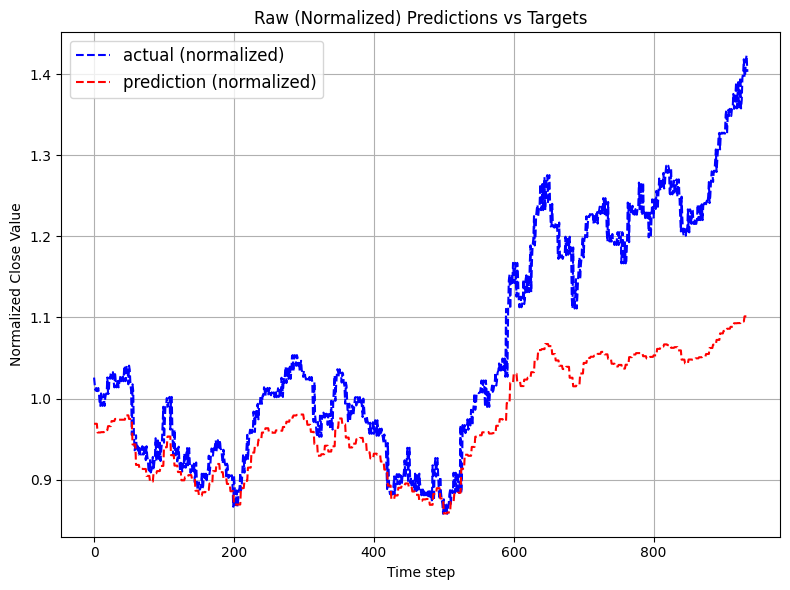

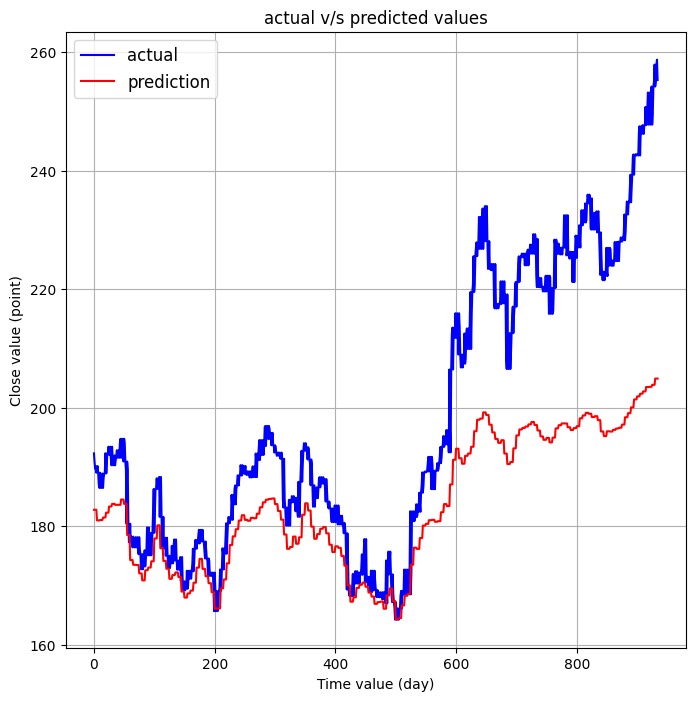

{'val_loss': 0.01361365520699139,
 'val_mae': 0.08778035640716553,
 'val_accuracy': 0.0}

In [13]:
print("here!")
trainer.evaluate(val_loader)